<a href="https://colab.research.google.com/github/Sudhandar/ResNet-50-model/blob/master/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
from google.colab import files

# Upload kaggle.json file downloaded from Kaggle account
uploaded = files.upload()

# Move the uploaded file to the required directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

 89% 25.0M/28.0M [00:01<00:00, 21.0MB/s]
100% 28.0M/28.0M [00:01<00:00, 18.2MB/s]


In [ ]:
!unzip -q alzheimer-mri-dataset -d data_folder

# Define data directory after extraction
data_dir = '/content/data_folder/Dataset'

In [ ]:
import numpy as np
import tensorflow as tf
import h5py
import math
# ------------------------------------- #
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

def load_dataset(data_dir, image_size, batch_size):
    train_ds = image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=image_size,
        batch_size=batch_size,
    )
    val_ds = image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=image_size,
        batch_size=batch_size,
    )

    classes = train_ds.class_names
    return train_ds, val_ds, classes

def preprocess_data(train_ds, val_ds, image_size, batch_size):
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    normalization_layer = layers.Rescaling(1./255)
    augmented_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    augmented_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    return augmented_train_ds, augmented_val_ds

# Define parameters
data_dir = '/content/data_folder/Dataset'
image_size = (64, 64)
batch_size = 32

# Load dataset
train_ds, val_ds, classes = load_dataset(data_dir, image_size, batch_size)

# Preprocess data
train_ds, val_ds = preprocess_data(train_ds, val_ds, image_size, batch_size)

# Example usage
for images, labels in train_ds.take(1):
    print(images.shape)  # Shape of the batch of images
    print(labels.numpy())  # Labels corresponding to the images


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)

    """

    m = X.shape[0]
    mini_batches = []
    np.random.seed(seed)

    # Shuffle
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Partition
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches


def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX

    """

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)

    return Z3

def predict(X, parameters):

    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])

    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}

    x = tf.placeholder("float", [12288, 1])

    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)

    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})

    return prediction

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.
(32, 64, 64, 3)
[3 2 2 2 3 3 3 2 2 2 2 0 3 2 2 2 0 2 3 3 2 2 2 2 2 2 2 2 3 2 2 0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install graphviz

In [ ]:
from tensorflow.keras.layers import BatchNormalization


In [ ]:
import numpy as np
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Add, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform

def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

def ResNet152(input_shape=(64, 64, 3), classes=6):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='g')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='h')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='i')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='j')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='k')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='l')

    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5,
    block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet152')
    return model

# Create ResNet152 model
model = ResNet152(input_shape=(64, 64, 3), classes=6)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "ResNet152"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d_1 (ZeroPadd  (None, 70, 70, 3)            0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 32, 32, 64)           9472      ['zero_padding2d_1[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1[0][0]']       

In [ ]:
import zipfile
import os

# Path to the ZIP file in Google Drive
zip_file_path = '/content/drive/MyDrive/train_data2.zip'

# Directory to extract the contents of the ZIP file
extracted_dir_path = '/content/data_folder/train_ds'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# List the contents of the extracted folder
extracted_files = os.listdir(extracted_dir_path)
print("Files extracted successfully:")
print(extracted_files)


Files extracted successfully:
['MildDemented', 'VeryMildDemented', 'NonDemented', 'ModerateDemented']


In [ ]:
import zipfile
import os

# Path to the ZIP file in Google Drive
zip_file_path = '/content/drive/MyDrive/test_data2.zip'

# Directory to extract the contents of the ZIP file
extracted_dir_path = '/content/data_folder/test_ds'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# List the contents of the extracted folder
extracted_files = os.listdir(extracted_dir_path)
print("Files extracted successfully:")
print(extracted_files)


Files extracted successfully:
['MildDemented', 'VeryMildDemented', 'NonDemented', 'ModerateDemented']


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

def load_dataset(train_dir, test_dir, image_size, batch_size):
    train_ds = image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=image_size,
        batch_size=batch_size,
    )
    val_ds = image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=image_size,
        batch_size=batch_size,
    )

    test_ds = image_dataset_from_directory(
        test_dir,
        seed=123,
        image_size=image_size,
        batch_size=batch_size,
    )

    classes = train_ds.class_names
    return train_ds, val_ds, test_ds, classes

# Define parameters
train_dir = '/content/data_folder/train_ds'
test_dir = '/content/data_folder/test_ds'
image_size = (64, 64)
batch_size = 32

# Load dataset
train_ds, val_ds, test_ds, classes = load_dataset(train_dir, test_dir, image_size, batch_size)

# Example usage
for images, labels in train_ds.take(1):
    print(images.shape)  # Shape of the batch of images
    print(labels.numpy())  # Labels corresponding to the images


Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.
Found 1279 files belonging to 4 classes.
(32, 64, 64, 3)
[2 2 0 2 2 3 2 3 2 3 0 2 2 3 0 0 0 3 2 2 2 2 2 2 2 0 3 3 0 2 2 2]


In [ ]:
def convert_to_one_hot(labels, num_classes):
    one_hot_labels = tf.one_hot(labels, depth=num_classes)
    return one_hot_labels.numpy()

# Load and preprocess datasets
# Assuming train_ds and test_ds are already loaded using image_dataset_from_directory
# image_size and batch_size are defined earlier
image_size = (64, 64)
batch_size = 32

# Example usage to get X_train, Y_train, X_test, Y_test, classes
def preprocess_dataset(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

X_train_orig, Y_train_orig = preprocess_dataset(train_ds)
X_test_orig, Y_test_orig = preprocess_dataset(test_ds)
classes = train_ds.class_names

# Normalize pixel values
X_train = X_train_orig.astype('float32') / 255.0
X_test = X_test_orig.astype('float32') / 255.0

# Convert labels to one-hot encoding
num_classes = len(classes)
Y_train = convert_to_one_hot(Y_train_orig, num_classes)
Y_test = convert_to_one_hot(Y_test_orig, num_classes)

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)
print("Classes:", classes)


X_train shape: (4097, 64, 64, 3)
Y_train shape: (4097, 4)
X_test shape: (1279, 64, 64, 3)
Y_test shape: (1279, 4)
Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

# Define the model with adjusted input shape
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile and fit the model as before


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(X_train, Y_train, epochs=20, batch_size=32)


Epoch 1/20
129/129 [==============================] - 7s 21ms/step - loss: 1.0394 - accuracy: 0.6156
Epoch 2/20
129/129 [==============================] - 3s 22ms/step - loss: 0.2310 - accuracy: 0.9319
Epoch 3/20
129/129 [==============================] - 2s 13ms/step - loss: 0.0768 - accuracy: 0.9836
Epoch 4/20
129/129 [==============================] - 1s 9ms/step - loss: 0.0287 - accuracy: 0.9980
Epoch 5/20
129/129 [==============================] - 1s 9ms/step - loss: 0.0152 - accuracy: 0.9990
Epoch 6/20
129/129 [==============================] - 1s 9ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 7/20
129/129 [==============================] - 1s 9ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 8/20
129/129 [==============================] - 1s 9ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 9/20
129/129 [==============================] - 1s 9ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 10/20
129/129 [==============================] - 1s 10ms/step - loss: 0.0010 - accuracy: 1.

In [ ]:
# train_dataset = train_dir
# train_set_x_orig = np.array(train_dataset["train_set_x"][:])
# train_set_y_orig = np.array(train_dataset["train_set_y"][:])

# test_dataset = test_dir
# test_set_x_orig = np.array(test_dataset["test_set_x"][:])
# test_set_y_orig = np.array(test_dataset["test_set_y"][:])

# classes = np.array(test_dataset["list_classes"][:])

# train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
# test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))


In [ ]:
# X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = train_set_x_orig,train_set_y_orig,test_set_x_orig,test_set_y_orig,classes
# X_train = X_train_orig/255.
# X_test = X_test_orig/255.
# Y_train = convert_to_one_hot(Y_train_orig, 6).T
# Y_test = convert_to_one_hot(Y_test_orig, 6).T



In [ ]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

40/40 [==============================] - 0s 4ms/step - loss: 2.9062 - accuracy: 0.5911
Loss = 2.906183958053589
Test Accuracy = 0.5910868048667908


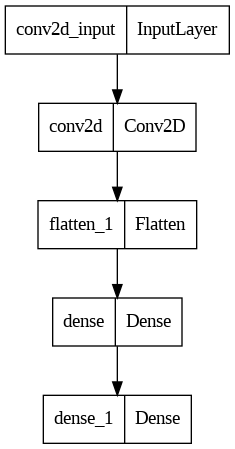

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='model_architecture.png')


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 flatten_1 (Flatten)         (None, 123008)            0         
                                                                 
 dense (Dense)               (None, 128)               15745152  
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15746564 (60.07 MB)
Trainable params: 15746564 (60.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Save the trained model
model.save('/content/saved_model')  # Replace 'path_to_save_model.h5' with your desired save path

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to preprocess uploaded image
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Load your trained model
model = load_model('/content/saved_model')

# Define target image size expected by your model
target_size = (64, 64)  # Adjust to match your model's input size

# Example usage:
uploaded_img_path = '/content/drive/MyDrive/test_image_demented.jpg'
preprocessed_img = preprocess_image(uploaded_img_path, target_size)

# Make predictions
predictions = model.predict(preprocessed_img)

# Interpret predictions
predicted_class_index = np.argmax(predictions)
predicted_class = classes[predicted_class_index]  # Assuming you have the class labels

# Display prediction result
print(f"Predicted class: {predicted_class}")


1/1 [==============================] - 0s 54ms/step
Predicted class: VeryMildDemented
